# A temperature-forecasting example
**Problem**: given a Time Series of hourly measurements (humidity, pressure, etc.), recorded over the recent past by a set of sensors on the roof of a building, we want to predict the temperature 24 hours in the future.

## The dataset
We’ll work with a weather timeseries [dataset](https://www.bgc-jena.mpg.de/wetter/) recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

### Downloading the data

In [1]:

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-29 16:06:47--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.12.122, 54.231.228.184, 16.182.40.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.12.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.6MB/s    in 0.6s    

2025-04-29 16:06:48 (20.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### Inspecting the data of the Jena weather dataset
The following snippet outputs a count of $420,551$ lines of data (each line is a timestep: a record of a date and 14 weather-related values), as well as its header.

In [2]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### Parsing the data
Now, convert all $420,551$ lines of data into NumPy arrays:
- One array for the temperature (in degrees Celsius);
- Another one for the rest of the data—the features we will use to predict future temperatures.

Note that we discard the _“Date Time”_ column.

In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

### Plotting the temperature timeseries

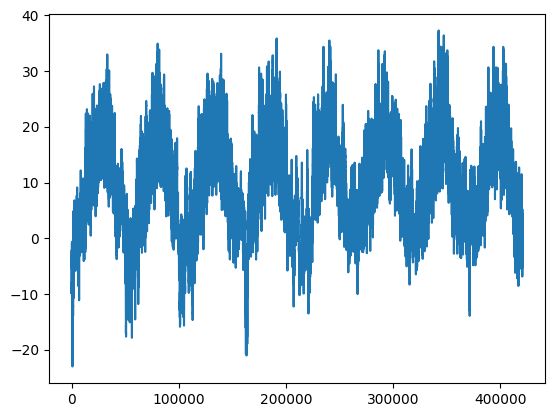

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

We can clearly see the yearly **periodicity** of temperature $-$ the data spans 8 years.

Periodicity over multiple timescales is an important and very common property of timeseries data. Whether you’re looking at the weather, mall parking occupancy, traffic to a website, sales of a grocery store, or steps logged in a fitness tracker, you’ll see daily cycles and yearly cycles (human-generated data also tends to feature weekly cycles).

When exploring your data, make sure to look for these patterns.

### Plotting the first 10 days of the temperature timeseries
Because the data is recorded every 10 minutes, you get $24 \times 6 = 144$ data points per day.

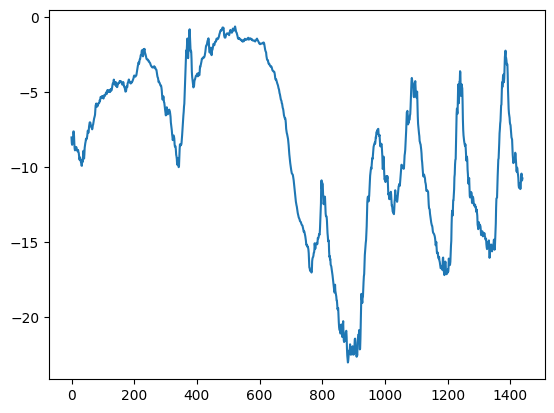

In [5]:
plt.plot(range(1440), temperature[:1440])

On this plot, we can see daily periodicity, especially for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

### Computing the number of samples we’ll use for each data split
We’ll use the first $50%$ of the data for training, the following $25%$ for validation, and the last $25%$ for testing.

When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to **predict the future given the past**, not the reverse, and your validation/test splits should reflect that.

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Preparing the data
The exact formulation of the problem will be as follows:

_<<Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?>>_

### Normalizing the data
First, let’s preprocess the data to a format a neural network can ingest.

The data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in _mbar_, is around $1,000$, while H2OC, measured in _millimoles per mole_, is around $3$). We’ll normalize each timeseries independently so that they all take small values on a similar scale.

We’re going to use the first $210,225$ timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### Instantiating datasets for training, validation, and testing
Next, let’s create a _Dataset_ object that yields batches of data from the past five days along with a target temperature 24 hours in the future.

Because the samples in the dataset are highly redundant (sample $N$ and sample $N + 1$ will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample.

Instead, we’ll generate the samples on the fly while only keeping in memory the original ```raw_data``` and ```temperature``` arrays, and nothing more.

We’ll use ```timeseries_dataset_from_array()``` to instantiate three datasets: one for training, one for validation, and one for testing.

We’ll use the following parameter values:
- ```sampling_rate = 6```—Observations will be sampled at one data point per hour: we will only keep one data point out of 6;
- ```sequence_length = 120```—Observations will go back 5 days (120 hours);
- ```delay = sampling_rate * (sequence_length + 24 - 1)```—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass ```start_index = 0``` and ```end_index = num_train_samples``` to only use the first $50%$ of the data.

For the validation dataset, we’ll pass ```start_index = num_train_samples``` and ```end_index = num_train_samples + num_val_samples``` to use the next $25%$ of the data.

Finally, for the test dataset, we’ll pass ```start_index = num_train_samples + num_val_samples``` to use the remaining samples.

In [8]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

### Inspecting the output of one of our datasets
Each dataset yields a tuple ```(samples, targets)```, where ```samples``` is a batch of $256$ samples, each containing $120$ consecutive hours of input data, and ```targets``` is the corresponding array of $256$ target temperatures.

Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## A common-sense, non-machine learning baseline
Before we start using black-box deep learning models to solve the temperature-prediction problem, let’s try a simple, **common-sense approach**. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet).

A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary
baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always
predict that the temperature 24 hours from now will be equal to the temperature right now.

### Computing the common-sense baseline MAE
Let’s evaluate the approach we discussed, using the mean absolute error (MAE) metric, defined as follows:
```math
	np.mean(np.abs(preds - targets))
```

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Let's try a basic machine learning model
In the same way that it’s useful to establish a common-sense baseline before trying machine learning approaches, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

### Training and evaluating a densely connected model
We define a fully connected model that starts by flattening the data and then runs it through two _Dense_ layers.

Note the lack of an activation function on the last _Dense_ layer, which is typical for a regression problem.

We use **mean squared error** (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth
around zero, which is a useful property for gradient descent.

We will monitor MAE by adding it as a metric in ```compile()```.

In [12]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - loss: 17.8471 - mae: 3.2051 - val_loss: 10.7330 - val_mae: 2.5921
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 9.3227 - mae: 2.3994 - val_loss: 13.1321 - val_mae: 2.8757
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 8.4922 - mae: 2.2914 - val_loss: 12.2968 - val_mae: 2.7820
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - loss: 8.0187 - mae: 2.2237 - val_loss: 11.2659 - val_mae: 2.6572
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 7.6454 - mae: 2.1718 - val_loss: 11.5380 - val_mae: 2.6812
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 40ms/step - loss: 7.3577 - mae: 2.1319 - val_loss: 10.9772 - val_mae: 2.6238
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 7.1918 - mae: 2.1072 - val_loss: 10.5588 - val_mae: 2.5660
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 6.9524 - mae: 2.0725 - val_loss: 10.6518 - val_mae: 2.5767
Epoch 9/10
819/819 ━━━━━━━━━━━━

### Plotting results
Let’s display the loss curves for validation and training.

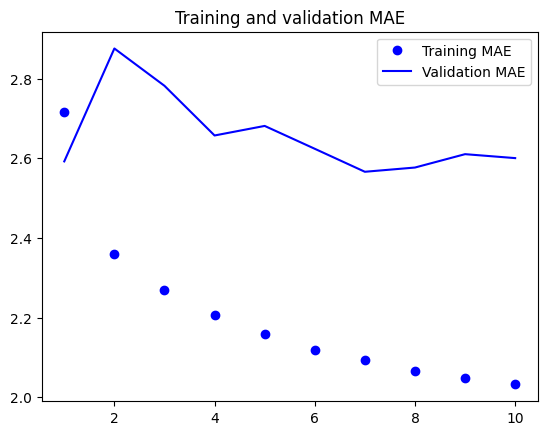

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform.

## Let's try a 1D convolutional model
Since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

We already used ```Conv2D``` and ```SeparableConv2D``` layers, which see their inputs through small windows that swipe across 2D grids. There are also 1D and even 3D versions of these layers: ```Conv1D```, ```SeparableConv1D```, and ```Conv3D```.

The ```Conv1D``` layer relies on 1D windows that slide across input sequences, and the ```Conv3D``` layer relies on
cubic windows that slide across input volumes.

You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via ```MaxPooling1D``` layers), we’ll reduce the window size accordingly:

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 46.4779 - mae: 5.1189 - val_loss: 18.1934 - val_mae: 3.4018
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - loss: 16.9107 - mae: 3.2746 - val_loss: 15.0054 - val_mae: 3.0535
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 15.5741 - mae: 3.1360 - val_loss: 14.7667 - val_mae: 3.0313
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 14.5995 - mae: 3.0383 - val_loss: 15.1861 - val_mae: 3.0709
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - loss: 13.9267 - mae: 2.9683 - val_loss: 14.5490 - val_mae: 3.0119
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 42ms/step - loss: 13.3255 - mae: 2.9024 - val_loss: 14.5080 - val_mae: 2.9757
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 12.8374 - mae: 2.8434 - val_loss: 14.4309 - val_mae: 3.0022
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 12.3854 - mae: 2.7931 - val_loss: 14.0330 - val_mae: 2.9441
Epoch 9/10
819/819 ━━━━━

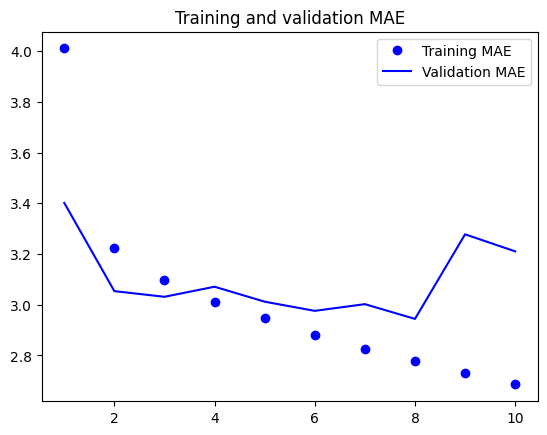

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

As it turns out, this model performs even worse than the densely connected one.

_What went wrong here?_ Two things:
1. **Weather data doesn’t quite respect the translation invariance assumption**. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
2. **Order in our data matters**. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

## A first recurrent baseline
Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time
from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information.

Let’s instead look at the data as what it is: a sequence, where causality and order matter.

### A simple LSTM-based model
There’s a family of neural network architectures designed specifically for this use case: **recurrent neural networks** (RNNs). Among them, the **Long Short Term Memory** (LSTM) layer has long been very popular.

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - loss: 75.8087 - mae: 6.7067 - val_loss: 13.8855 - val_mae: 2.8010
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 12.5193 - mae: 2.7109 - val_loss: 10.1558 - val_mae: 2.4632
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 10.0719 - mae: 2.4720 - val_loss: 9.5390 - val_mae: 2.4084
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 9.5055 - mae: 2.4068 - val_loss: 9.5848 - val_mae: 2.4021
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 9.0872 - mae: 2.3544 - val_loss: 9.5528 - val_mae: 2.3911
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 8.7991 - mae: 2.3152 - val_loss: 9.4028 - val_mae: 2.3676
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 8.4897 - mae: 2.2762 - val_loss: 9.4311 - val_mae: 2.3831
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 8.2840 - mae: 2.2504 - val_loss: 9.4301 - val_mae: 2.3838
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

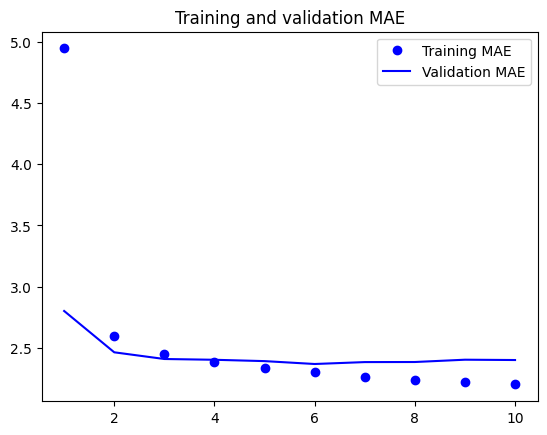

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of machine learning on this task.